In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import time 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder,OrdinalEncoder,RobustScaler,MinMaxScaler
from sklearn.metrics import plot_confusion_matrix, classification_report,accuracy_score,roc_auc_score, confusion_matrix, classification_report,precision_score,recall_score,plot_roc_curve,log_loss
from pandas.plotting import scatter_matrix
import plotly.express as px
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
import category_encoders as ce
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from numpy import asarray
# from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import SMOTE

%matplotlib inline


In [2]:
vs = []
ds = []
vs.append('Variables')
ds.append('Description')

vs.append('enrollee_id')
ds.append('Unique ID for candidate')

vs.append('city')
ds.append('City code')

vs.append('city_development_index')
ds.append('Development index of the city (scaled)')

vs.append('gender')
ds.append('Gender of candidate')

vs.append('relevent_experience')
ds.append('Relevant experience of candidate')

vs.append('enrolled_university')
ds.append('Type of University course enrolled if any')

vs.append('education_level')
ds.append('Education level of candidate')

vs.append('major_discipline')
ds.append('Education major discipline of candidate')

vs.append('experience')
ds.append('Candidate total experience in years')

vs.append('company_size')
ds.append('No of employees in current employer’s company')

vs.append('company_type')
ds.append('Type of current employer')

vs.append('last_new_job')
ds.append('Difference in years between previous job and current job')

vs.append('training_hours')
ds.append('training hours completed')

vs.append('target')
ds.append('0: Not looking for job change, 1: Looking for a job change')

pd.DataFrame({vs[0]:vs[1:],ds[0]:ds[1:]}).style.set_properties(**{'text-align': 'right'})

,Variables,Description
0,enrollee_id,Unique ID for candidate
1,city,City code
2,city_development_index,Development index of the city (scaled)
3,gender,Gender of candidate
4,relevent_experience,Relevant experience of candidate
5,enrolled_university,Type of University course enrolled if any
6,education_level,Education level of candidate
7,major_discipline,Education major discipline of candidate
8,experience,Candidate total experience in years
9,company_size,No of employees in current employer’s company


In [3]:
def one_hot_encoding(df,col):
    one_hot_encoder=ce.OneHotEncoder(cols=col,return_df=True,use_cat_names=True)
    df_final = one_hot_encoder.fit_transform(df)
    return df_final

In [4]:
def bar_plot_proportion(x, hue, data,hue_order=None, text = True, 
                        order = None, y="proportion",x_labels=[]):
  '''
  x: values of x
  y: name of y
  hue: group variable
  hue_order: order of group variable
  text: whether there are texts(percentages) above bar plot
  order: order of x
  x_labels: list of xstck labels
  '''
  #group by x, percentage of sum of each group of x, multiple 100
  #rename calculated column as y
  df=data
  d1 = (df[hue]
  .groupby(df[x])
  .value_counts(normalize = True)
  .mul(100)
  .rename(y)
  .reset_index())

  #draw bar plot
  g = sns.catplot(kind='bar', data=d1, x=x, y=y, hue=hue, 
                  hue_order=hue_order, order = order,height=5, aspect=2)
  
  #set limitation of y
  g.ax.set_ylim(0,100)

  #set title
  g.set(title='Influence of ' + x + ' on ' + hue)

  #add text(percentage) above bar
  if text == True:
    for p in g.ax.patches:
      txt = str(p.get_height().round(2)) + '%'
      txt_x = p.get_x() 
      txt_y = p.get_height() + 2
      g.ax.text(txt_x,txt_y,txt)  

  labels = [item.get_text() for item in g.ax.get_xticklabels()]
  if x_labels != []:
    labels = x_labels
  g.ax.set_xticklabels(labels)
  plt.figure(figsize=(10,10))
  plt.show()

In [5]:
def metrics(Y_test,Y_pred):
    print("\n")
    print("Accuracy :",accuracy_score(Y_pred,Y_test))
    print("\n")
    print("Precision Score : ",precision_score(Y_pred,Y_test))
    print("\n")
    print("Recall Score : ",recall_score(Y_pred,Y_test))
    print("\n")
    print("ROC AUC Score : ",roc_auc_score(Y_pred,Y_test))
    print("\n")
    print("Classification Report\n\n",classification_report(Y_pred,Y_test))
    print("\n")
    cf_matrix = confusion_matrix(Y_pred,Y_test)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    print("Confusion Matrix")
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
    plt.plot()
    plt.show()

In [6]:
class Modelling:
    def __init__(self, X_train, Y_train, X_test, Y_test, models):
        self.X_train = X_train
        self.X_test = X_test
        self.Y_train = Y_train
        self.Y_test = Y_test
        self.models = models
    
    def fit(self):
        model_acc = []
        model_time= []
        error_rate=[]
       
        for i in self.models:
            start=time.time()
            if i == 'knn':
                accuracy = []
                for j in range(1,200):    
                    kn = KNeighborsClassifier(n_neighbors=j)
                    kn.fit(self.X_train,self.Y_train)
                    predK = kn.predict(self.X_test)
                    metrics(predK,self.Y_test)
                    error_rate.append(np.mean(predK != self.Y_test))
                    accuracy.append([accuracy_score(self.Y_test,predK),j])
                temp = accuracy[0]
                plt.figure(figsize=(10,6))
                plt.plot(range(2,40),error_rate,color='blue', linestyle='dashed', marker='o',
                  markerfacecolor='red', markersize=10)
                plt.title('Error Rate vs. K Value')
                plt.xlabel('K')
                plt.ylabel('Error Rate')
                plt.show()
                for m in accuracy:
                    if temp[0] < m[0]:
                        temp=m
                i = KNeighborsClassifier(n_neighbors=temp[1])
            i.fit(self.X_train,self.Y_train)
            
            model_acc.append(accuracy_score(self.Y_test,i.predict(self.X_test)))
            stop=time.time()
            model_time.append((stop-start))
            print(i,'has been fit')
            metrics(i.predict(self.X_test),self.Y_test)
        self.models_output = pd.DataFrame({'Models':self.models,'Accuracy':model_acc,'Runtime (s)':model_time})

        
        
    def results(self):
        models=self.models_output
        models = models.sort_values(by=['Accuracy','Runtime (s)'],ascending=[False,True]).reset_index().drop('index',axis=1)
        self.best = models['Models'][0]
        models['Models']=models['Models'].astype(str).str.split("(", n = 2, expand = True)[0]
        models['Accuracy']=models['Accuracy'].round(5)*100
        self.models_output_cleaned=models
        
        return(models)
        
    def best_model(self,type):
        if type=='model':
            return(self.best)
        elif type=='name':
            return(self.models_output_cleaned['Models'][0])
    
    def best_model_accuracy(self):
        return(self.models_output_cleaned['Accuracy'][0])
    
    def best_model_runtime(self):
        return(round(self.models_output_cleaned['Runtime (s)'][0],3))
    
    def best_model_predict(self,X_test):
        return(self.best.predict(X_test))
    
    def best_model_clmatrix(self):
        return(classification_report(self.Y_test,self.best.predict(self.X_test)))

In [7]:
train_df = pd.read_csv('aug_train.csv')
test_df = pd.read_csv('aug_test.csv')
print(train_df.shape)
print(test_df.shape)

(19158, 14)
(2129, 13)


In [8]:
train_df.sample(10)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
17640,29042,city_103,0.920,Male,No relevent experience,Part time course,Graduate,STEM,5,10000+,Pvt Ltd,1,39,0.0
16044,8946,city_76,0.698,Male,No relevent experience,no_enrollment,Graduate,STEM,4,50-99,Pvt Ltd,1,16,1.0
15816,8288,city_13,0.827,NaN,Has relevent experience,no_enrollment,Graduate,STEM,13,<10,Pvt Ltd,1,206,0.0
17805,8121,city_114,0.926,NaN,Has relevent experience,Full time course,High School,NaN,6,50-99,NaN,2,13,0.0
9320,5264,city_100,0.887,Male,No relevent experience,no_enrollment,High School,NaN,3,NaN,NaN,never,96,0.0
15958,10026,city_104,0.924,Male,No relevent experience,Full time course,Graduate,STEM,9,100-500,NaN,1,44,0.0
3775,13766,city_144,0.840,Male,Has relevent experience,no_enrollment,Graduate,STEM,8,<10,Pvt Ltd,1,9,0.0
7144,26547,city_102,0.804,NaN,No relevent experience,no_enrollment,Masters,Business Degree,2,50-99,Pvt Ltd,1,60,0.0
17559,28585,city_104,0.924,Male,Has relevent experience,no_enrollment,Graduate,STEM,5,500-999,Pvt Ltd,1,18,0.0
15694,25597,city_160,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,11,100-500,Pvt Ltd,2,190,0.0


In [9]:
#type of features
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

### Exploratory Data Analysis(EDA)

In [10]:
train_df.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [11]:
train_df.gender.value_counts(dropna=False)
train_df['gender'] = train_df['gender'].fillna('Prefer not to say')

In [12]:
train_df.skew().sort_values(ascending=False)

/var/folders/lm/qkcrvy853g79ybtncmbrw98w0000gn/T/ipykernel_89137/3115622433.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_df.skew().sort_values(ascending=False)


training_hours            1.819237
target                    1.158815
enrollee_id              -0.018391
city_development_index   -0.995428
dtype: float64

In [13]:
train_df['experience'].replace('<1',0,inplace=True)
train_df['experience'].replace('>20',21,inplace=True)
train_df['last_new_job'].replace('>4',5,inplace=True)


In [14]:
train_df.enrolled_university.value_counts(dropna=False)
t1 = train_df[(train_df.enrolled_university == 'no_enrollment') & 
        ((train_df.education_level == 'Masters')|(train_df.education_level == 'Phd'))]
print(len(t1))

t2 = train_df[(train_df.enrolled_university == 'Full time course') & 
        ((train_df.education_level == 'High School')|(train_df.education_level == 'Primary School'))]
print(len(t2))

#Dropping the column
train_df.drop(['enrolled_university'], axis=1,inplace=True) 
 



3918
897


- In this dataset, 3918 people claimed they did not enroll in a university despite having a master's or doctoral degree, and 897 people claimed they had taken a full-time course while still in high school or elementary school. It is a clear paradox. We assume that the variable enrolled university contains some muddle. We exclude "enrolled university" to prevent confusion because "education level" already provides sufficient information about educational level.

In [15]:

train_df.education_level.value_counts(dropna=False)

Graduate          11598
Masters            4361
High School        2017
NaN                 460
Phd                 414
Primary School      308
Name: education_level, dtype: int64

- In this dataset, there are five distinct values in 'education_level' except 'na' while 'Graduate' forms a sizeable majority. Meantime there is another value which is 'Masters'. It can be speculated that 'Graduate' means one has got a bachelor's degree.


In [16]:
for i in ('High School', 'Primary School'):
    train_df.loc[train_df.education_level == i, 'major_discipline'].fillna('No Major',inplace=True)

train_df.dropna(subset = ['education_level','major_discipline'],inplace=True)
train_df.dropna(subset = ['experience','last_new_job'],inplace=True)
train_df['last_new_job'].replace('never',0,inplace=True)

    
train_df.isnull().sum()



enrollee_id                  0
city                         0
city_development_index       0
gender                       0
relevent_experience          0
education_level              0
major_discipline             0
experience                   0
company_size              4084
company_type              4331
last_new_job                 0
training_hours               0
target                       0
dtype: int64

In [17]:
train_df.loc[train_df['company_size'] == '10/49','company_size'] = '10-49'
train_df.loc[train_df['company_size'] == '<10','company_size'] = '1-9'
train_df['company_size'].fillna('No info',inplace=True)

In [18]:
train_df['company_type'].fillna('Missing',inplace=True)

In [19]:
print(train_df.isna().sum())
print(train_df.shape)

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64
(16007, 13)


In [20]:
pd.pivot_table(train_df, values='enrollee_id', index='company_type', columns = ['company_size'], aggfunc='count')

company_size,1-9,10-49,100-500,1000-4999,10000+,50-99,500-999,5000-9999,No info
company_type,,,,,,,,,
Early Stage Startup,234.0,155.0,24.0,NaN,NaN,99.0,2.0,NaN,2.0
Funded Startup,126.0,182.0,204.0,NaN,NaN,355.0,54.0,NaN,4.0
Missing,51.0,83.0,124.0,51.0,64.0,184.0,57.0,24.0,3693.0
NGO,30.0,27.0,163.0,70.0,37.0,67.0,35.0,29.0,20.0
Other,9.0,10.0,15.0,15.0,12.0,18.0,9.0,7.0,7.0
Public Sector,28.0,37.0,135.0,156.0,133.0,98.0,82.0,72.0,109.0
Pvt Ltd,633.0,796.0,1685.0,914.0,1633.0,1940.0,573.0,382.0,249.0


In [21]:
for i in train_df.columns:
    print(i,"has",train_df[i].nunique()," unique values")
    print()

enrollee_id has 16007  unique values

city has 122  unique values

city_development_index has 93  unique values

gender has 4  unique values

relevent_experience has 2  unique values

education_level has 3  unique values

major_discipline has 6  unique values

experience has 22  unique values

company_size has 9  unique values

company_type has 7  unique values

last_new_job has 6  unique values

training_hours has 241  unique values

target has 2  unique values



In [22]:
for i in ['gender','relevent_experience','education_level','major_discipline','company_size','company_type','last_new_job']:
    ct=pd.crosstab(train_df.target, train_df[i])
    print(ct)

gender  Female  Male  Other  Prefer not to say
target                                        
0.0        850  8634    102               2332
1.0        303  2677     40               1069
relevent_experience  Has relevent experience  No relevent experience
target                                                              
0.0                                     9781                    2137
1.0                                     2723                    1366
education_level  Graduate  Masters  Phd
target                                 
0.0                  8197     3372  349
1.0                  3131      902   56
major_discipline  Arts  Business Degree  Humanities  No Major  Other   STEM
target                                                                     
0.0                197              239         525       162    274  10521
1.0                 53               85         137        54     94   3666
company_size  1-9  10-49  100-500  1000-4999  10000+  50-99  500-999  \


In [23]:
train_df_categorical = train_df.select_dtypes(include='object')
train_df_numerical = train_df.select_dtypes(exclude='object')

In [24]:
print(train_df_numerical.describe())

print()

print(train_df_categorical.describe())


        enrollee_id  city_development_index  training_hours        target
count  16007.000000            16007.000000    16007.000000  16007.000000
mean   16915.839695                0.829884       65.237771      0.255451
std     9665.371683                0.123188       60.021561      0.436128
min        2.000000                0.448000        1.000000      0.000000
25%     8575.500000                0.742500       23.000000      0.000000
50%    17023.000000                0.910000       47.000000      0.000000
75%    25318.000000                0.920000       88.000000      1.000000
max    33380.000000                0.949000      336.000000      1.000000

            city gender      relevent_experience education_level  \
count      16007  16007                    16007           16007   
unique       122      4                        2               3   
top     city_103   Male  Has relevent experience        Graduate   
freq        3903  11311                    12504           11

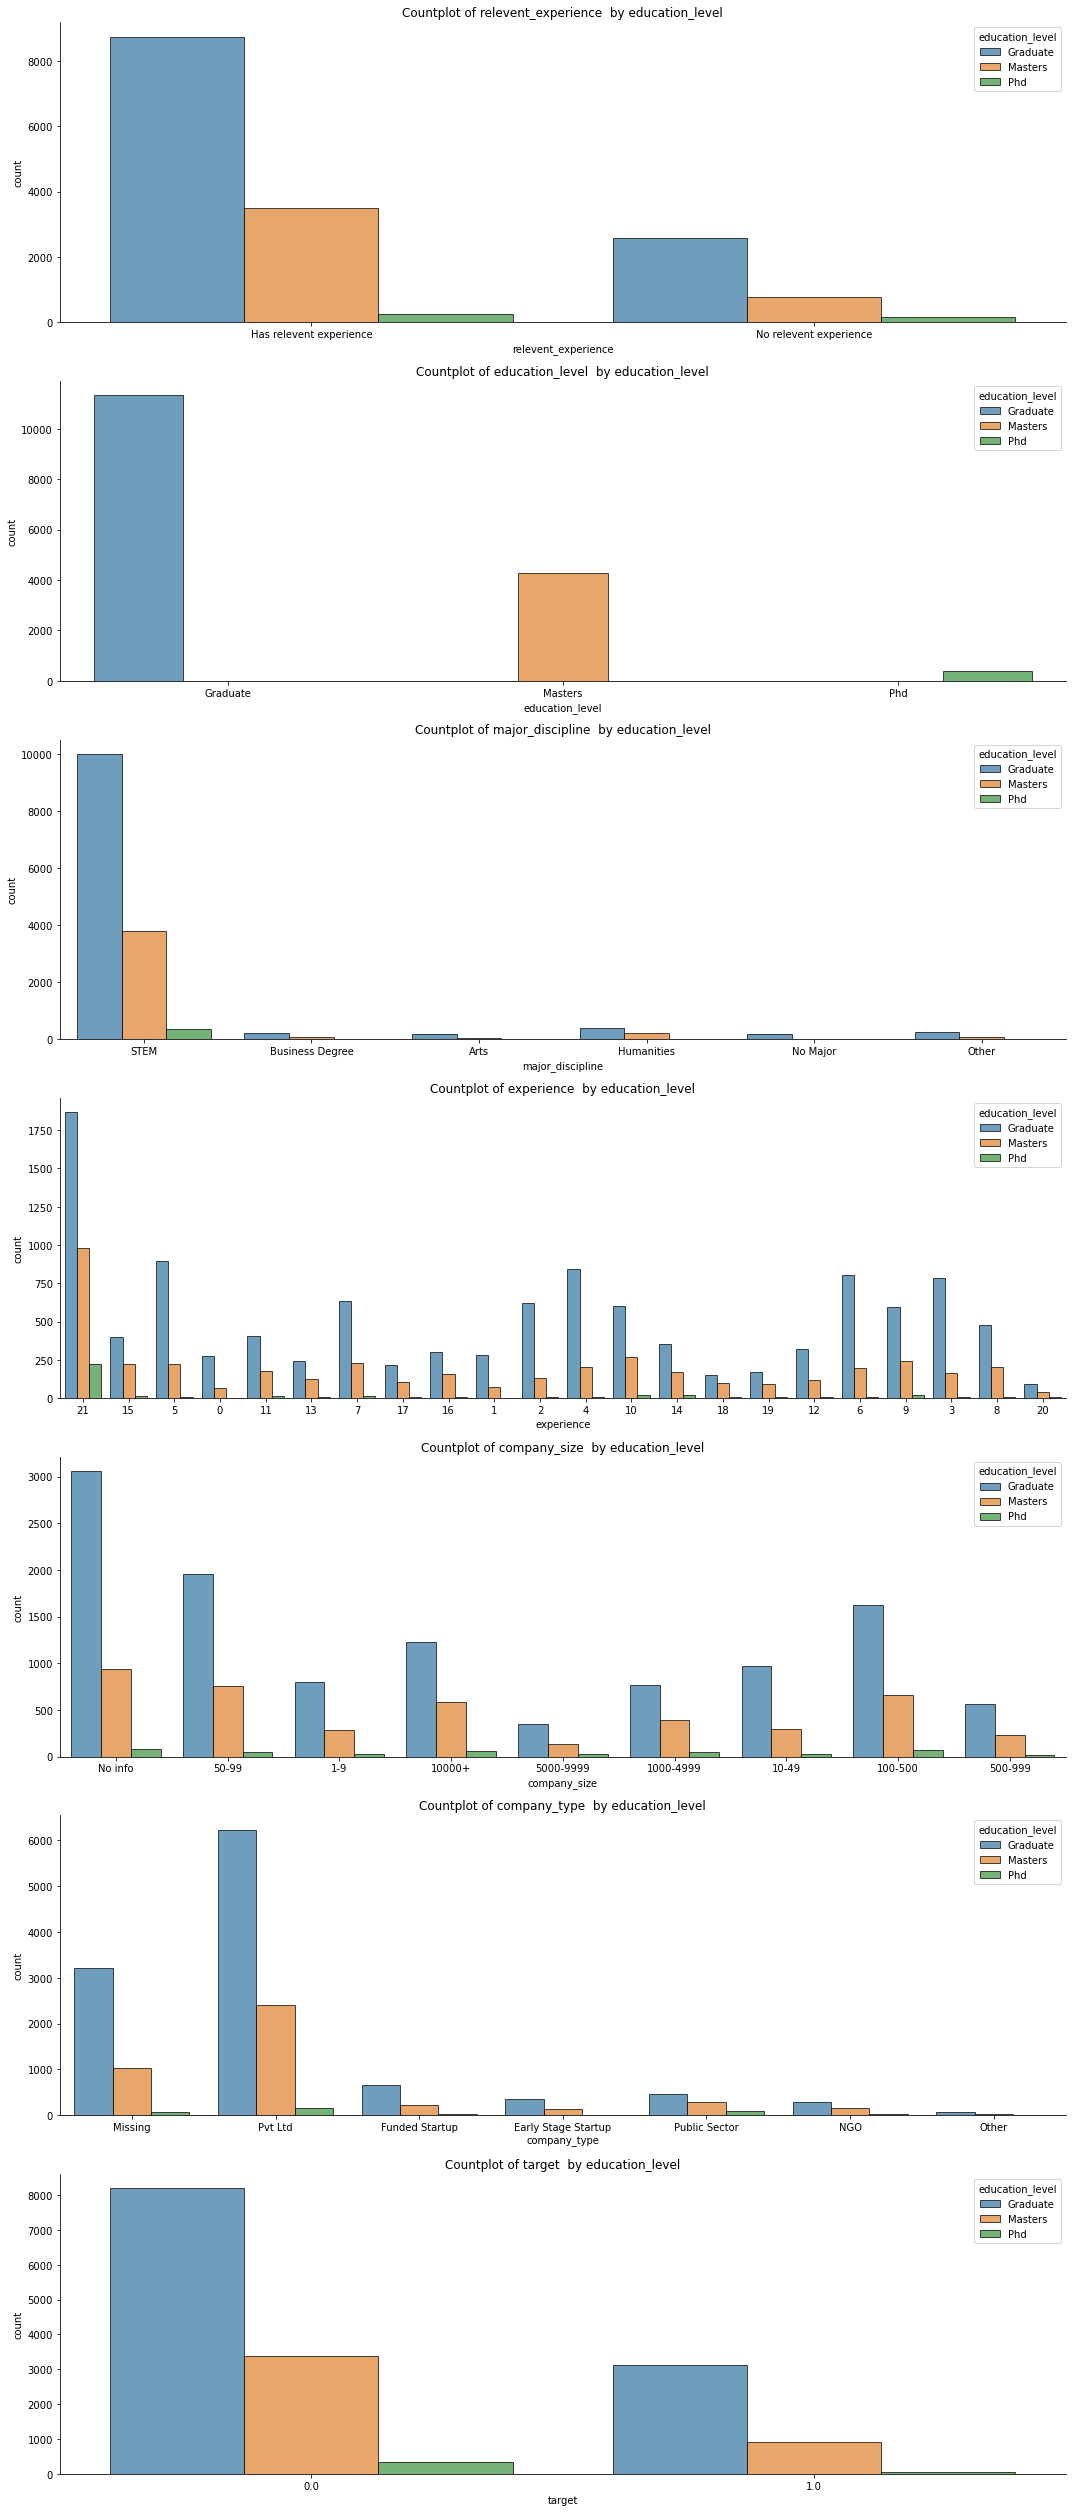

In [25]:
plt.figure(figsize=[15,35])
plot=["relevent_experience", "education_level","major_discipline", "experience","company_size","company_type","target"]
n=1
for f in plot:
    plt.subplots_adjust(hspace=2)
    plt.subplot(7,1,n)
    
    sns.countplot(x=f, hue='education_level', edgecolor="black", alpha=0.7, data=train_df)
    sns.despine()
    plt.title("Countplot of {}  by education_level".format(f))
    n=n+1
plt.tight_layout()
plt.show()

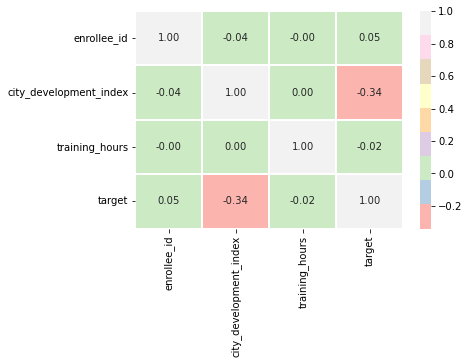

In [26]:
corr=train_df_numerical.corr()
sns.heatmap(corr,annot=True,cmap='Pastel1',fmt='.2f',linewidth=0.1,linecolor='white')
plt.show()

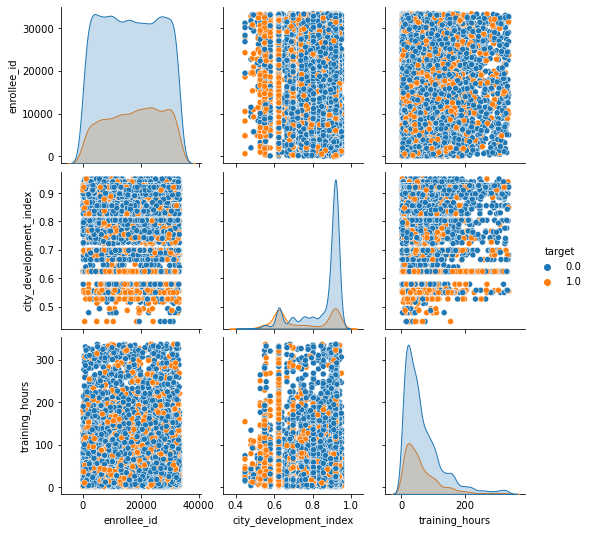

In [27]:
sns.pairplot(train_df_numerical, hue='target')

In [28]:
print("skewness score")
train_df.skew(axis=0)

skewness score


/var/folders/lm/qkcrvy853g79ybtncmbrw98w0000gn/T/ipykernel_89137/2655067996.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_df.skew(axis=0)


enrollee_id              -0.024246
city_development_index   -1.009426
experience                0.286347
last_new_job              0.736688
training_hours            1.828545
target                    1.121597
dtype: float64

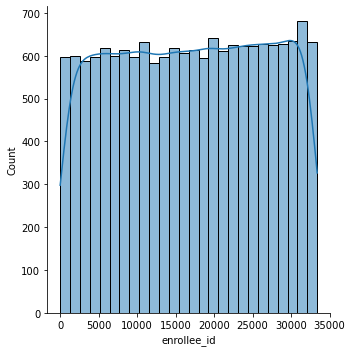

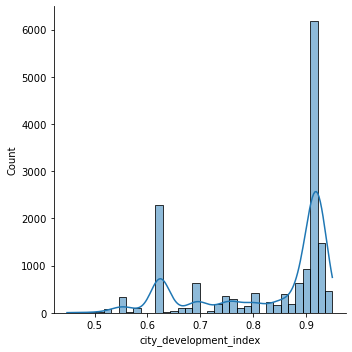

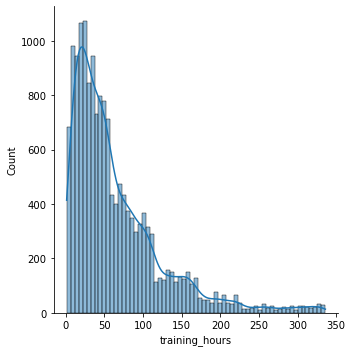

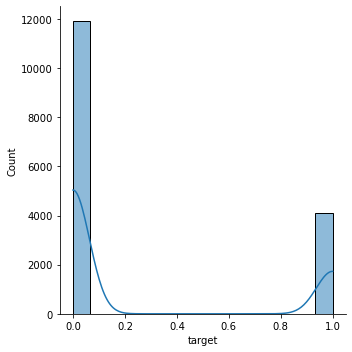

In [29]:
for i in train_df_numerical.columns:
    sns.displot(train_df[i],kde=True)

cities' number in dataset is  122


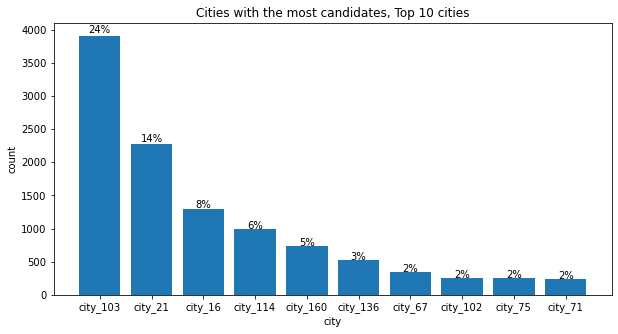

In [30]:
city_freq = train_df.groupby('city').count().sort_values('enrollee_id', ascending=False).head(10)['enrollee_id']

print("cities' number in dataset is ", len(train_df.groupby('city').count().reset_index()['city']))

plt.figure(figsize=(10,5))
graph = plt.bar([str(i) for i in city_freq.keys()], city_freq.values)
plt.title('Cities with the most candidates, Top 10 cities')
plt.xlabel('city')
plt.ylabel('count')
# add_value_label([str(i) for i in city_freq.keys()], city_freq.values)
i = 0
for p in graph:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()
     
    plt.text(x+width/2,
             y+height*1.01+1,
             str(round(100*city_freq.values[i]/train_df['target'].count()))+'%',
             ha='center')
    i += 1

- Out of the 123 cities, we can see that the top 4 cities represent over half of the candidates, with city_103 accounting for almost a quarter.



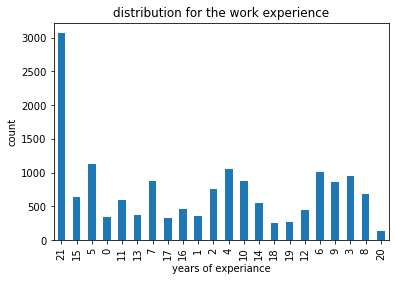

In [31]:
ax = train_df.experience.value_counts().loc[(train_df.experience.unique().tolist())].plot.bar(
                                    xlabel='years of experiance', 
                                    ylabel='count', 
                                    title='distribution for the work experience')


In [32]:
train_df.experience.unique()

array([21, '15', '5', 0, '11', '13', '7', '17', '16', '1', '2', '4', '10',
       '14', '18', '19', '12', '6', '9', '3', '8', '20'], dtype=object)

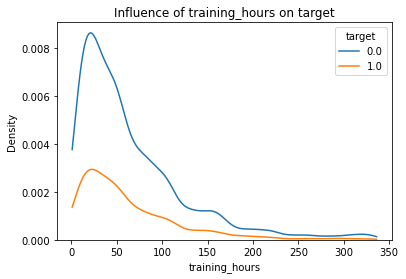

In [33]:
sns.kdeplot(data=train_df, x="training_hours", hue="target",cut = 0)
plt.title('Influence of training_hours on target')
plt.show()

Text(0.5, 1.0, 'Influence of city_development_index on target')

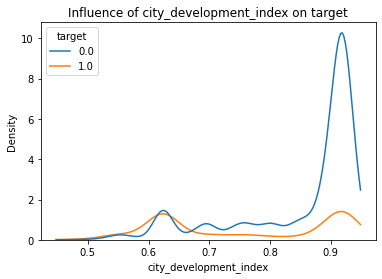

In [34]:
sns.kdeplot(data=train_df, x='city_development_index', hue='target',cut = 0)
plt.title('Influence of city_development_index on target')

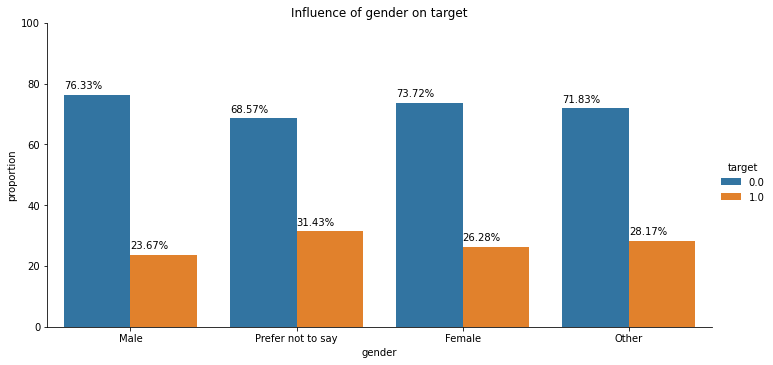

<Figure size 720x720 with 0 Axes>

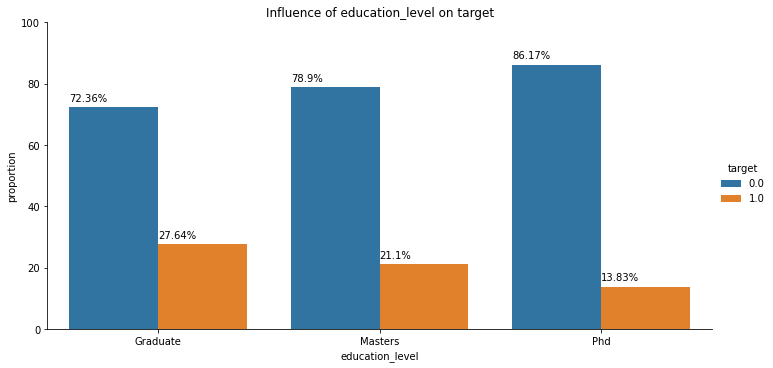

<Figure size 720x720 with 0 Axes>

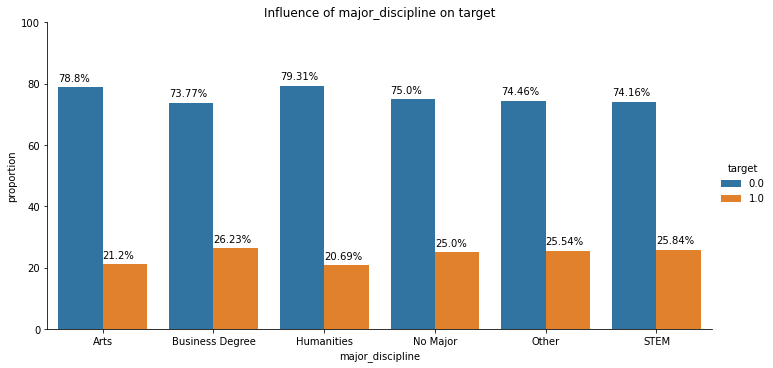

<Figure size 720x720 with 0 Axes>

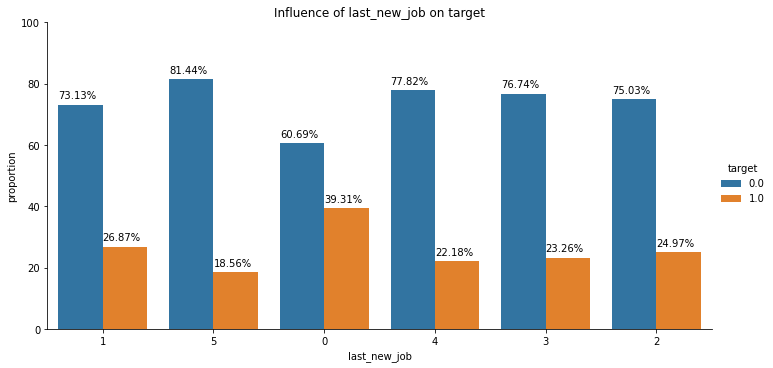

<Figure size 720x720 with 0 Axes>

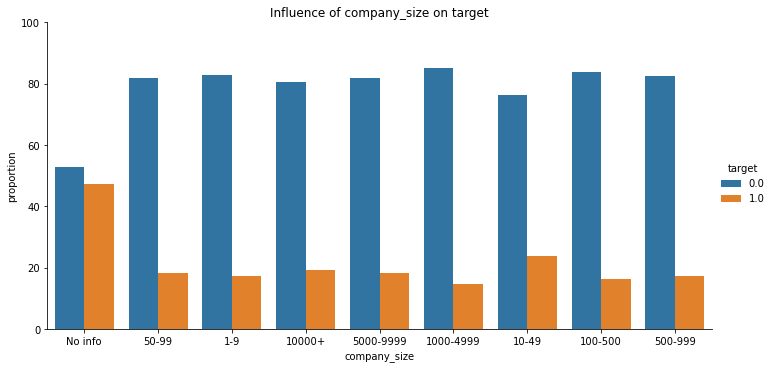

<Figure size 720x720 with 0 Axes>

In [35]:
bar_plot_proportion(hue='target', x='gender', order=train_df['gender'].unique().tolist(),data=train_df)
bar_plot_proportion(hue='target', y='proportion', x='education_level',order=train_df['education_level'].unique().tolist(),data=train_df)
bar_plot_proportion(hue='target', y='proportion', x='major_discipline',data=train_df)
bar_plot_proportion(hue='target', y='proportion', x='last_new_job',order=train_df['last_new_job'].unique().tolist(),data=train_df )
bar_plot_proportion(hue='target', y='proportion', x='company_size', text=False, order=train_df['company_size'].unique().tolist(),data=train_df )


<AxesSubplot:xlabel='company_type', ylabel='count'>

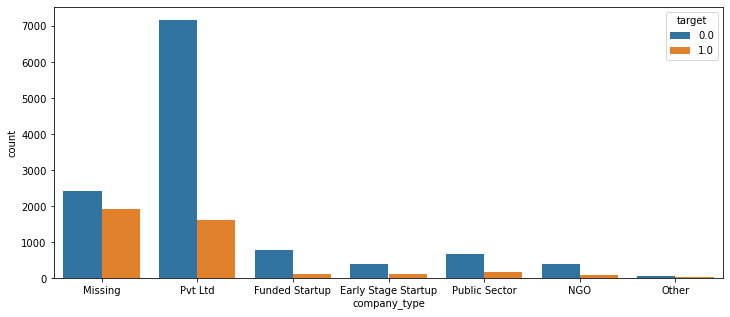

In [36]:
import matplotlib.pyplot as plt
  
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(12, 5))
sns.countplot(data = train_df,x = 'company_type',hue='target',ax=ax)


In [37]:
train_df.drop(['enrollee_id','company_size','city'],axis=1,inplace=True)

In [38]:
train_df.isna().sum()

city_development_index    0
gender                    0
relevent_experience       0
education_level           0
major_discipline          0
experience                0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [39]:
train_df['training_hours']=np.log(train_df['training_hours'])
df_scaled = train_df.copy()
columns = ['training_hours','last_new_job', 'city_development_index','experience']
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(train_df[columns])
features_scaled = pd.DataFrame(features_scaled, columns=columns)
df_scaled.drop(columns, axis=1, inplace=True)
df_scaled.reset_index(drop=True, inplace=True)
features_scaled.reset_index(drop=True, inplace=True)
df_scaled=pd.concat([df_scaled,features_scaled],axis=1)
df_scaled

,gender,relevent_experience,education_level,major_discipline,company_type,target,training_hours,last_new_job,city_development_index,experience
0,Male,Has relevent experience,Graduate,STEM,Missing,1.0,0.616031,0.2,0.942116,1.000000
1,Male,No relevent experience,Graduate,STEM,Pvt Ltd,0.0,0.661866,1.0,0.654691,0.714286
2,Prefer not to say,No relevent experience,Graduate,STEM,Missing,0.0,0.759628,0.0,0.351297,0.238095
3,Prefer not to say,No relevent experience,Graduate,Business Degree,Pvt Ltd,1.0,0.679245,0.0,0.680639,0.000000
4,Male,Has relevent experience,Masters,STEM,Funded Startup,0.0,0.357470,0.8,0.636727,1.000000
...,...,...,...,...,...,...,...,...,...,...
16002,Female,Has relevent experience,Graduate,STEM,Public Sector,0.0,0.539012,0.6,0.942116,0.476190
16003,Female,Has relevent experience,Graduate,Humanities,Funded Startup,0.0,0.553346,0.2,0.942116,0.333333
16004,Male,No relevent experience,Graduate,Humanities,Missing,1.0,0.642530,0.2,0.858283,0.666667
16005,Male,Has relevent experience,Graduate,STEM,Missing,1.0,0.679245,0.8,0.942116,0.666667


In [40]:
for i in ['gender', 'relevent_experience', 'major_discipline', 'company_type','education_level']:
    df_scaled=one_hot_encoding(df_scaled,i)
df_scaled

,gender_Male,gender_Prefer not to say,gender_Female,gender_Other,relevent_experience_Has relevent experience,relevent_experience_No relevent experience,education_level_Graduate,education_level_Masters,education_level_Phd,major_discipline_STEM,...,company_type_Funded Startup,company_type_Early Stage Startup,company_type_Public Sector,company_type_NGO,company_type_Other,target,training_hours,last_new_job,city_development_index,experience
0,1,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,1.0,0.616031,0.2,0.942116,1.000000
1,1,0,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0.0,0.661866,1.0,0.654691,0.714286
2,0,1,0,0,0,1,1,0,0,1,...,0,0,0,0,0,0.0,0.759628,0.0,0.351297,0.238095
3,0,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,1.0,0.679245,0.0,0.680639,0.000000
4,1,0,0,0,1,0,0,1,0,1,...,1,0,0,0,0,0.0,0.357470,0.8,0.636727,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16002,0,0,1,0,1,0,1,0,0,1,...,0,0,1,0,0,0.0,0.539012,0.6,0.942116,0.476190
16003,0,0,1,0,1,0,1,0,0,0,...,1,0,0,0,0,0.0,0.553346,0.2,0.942116,0.333333
16004,1,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,1.0,0.642530,0.2,0.858283,0.666667
16005,1,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,1.0,0.679245,0.8,0.942116,0.666667


In [41]:
X = df_scaled.drop(['target'], axis=1)
Y = pd.DataFrame(df_scaled['target'])

- As here we have imbalanced data, the number of 1 ( Looking for a job change) is around 20% of the whole data < 0 (Not looking for job change) is around 80% of the whole data, we have to upscale them accordinly to maintain a balanced state and to overcome the bias of model

# Upsmapling / Oversampling


In [42]:
smote = SMOTE()
X, Y = smote.fit_resample(X, Y)
print('After Upsampling using SMOTE technique\n' ,Y['target'].value_counts())
print('After Upsampling using SMOTE technique\n',  X.shape)

After Upsampling using SMOTE technique
 1.0    11918
0.0    11918
Name: target, dtype: int64
After Upsampling using SMOTE technique
 (23836, 26)


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25,random_state = 9)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(17877, 26) (5959, 26) (17877,) (5959,)


In [44]:
classifier=[]  #to store the model names
imported_as=[] #to store the instances of the models
lr = LogisticRegression(max_iter=1000)  #creating instance
classifier.append('Logistic Regression')
imported_as.append('lr')
knn = KNeighborsClassifier()
classifier.append('k Nearest Neighbours')
imported_as.append('knn')
rf = RandomForestClassifier()
classifier.append('Random Forest')
imported_as.append('rf')
dt = DecisionTreeClassifier()
classifier.append('Decision Tree')
imported_as.append('dt')
mnb=MultinomialNB()
classifier.append(' Multinominal NB')
imported_as.append('mnb')

classifiers = pd.DataFrame({'Classifier':classifier,'Imported as':imported_as})
display(classifiers)


,Classifier,Imported as
0,Logistic Regression,lr
1,k Nearest Neighbours,knn
2,Random Forest,rf
3,Decision Tree,dt
4,Multinominal NB,mnb


- If we just use a logistic model which do not contain regularization, it is not necessary to normalize data. However, if we want to use regularization and analyze the importance of parameters, normalization is needed. In this part, we use LogisticRegressionCV with L2 penalty to fit the data with the best C of regularization. 

- Numerical columns need to normalized and categorical columns need to be transformed into encoded values.



RandomForestClassifier() has been fit


Accuracy : 0.8286625272696762


Precision Score :  0.8240469208211144


Recall Score :  0.8401993355481727


ROC AUC Score :  0.8285432079571993


Classification Report

               precision    recall  f1-score   support

         0.0       0.83      0.82      0.83      2949
         1.0       0.82      0.84      0.83      3010

    accuracy                           0.83      5959
   macro avg       0.83      0.83      0.83      5959
weighted avg       0.83      0.83      0.83      5959



Confusion Matrix


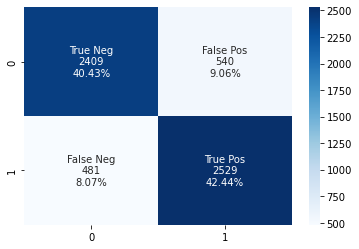

LogisticRegression(max_iter=1000) has been fit


Accuracy : 0.7440845779493204


Precision Score :  0.7374480332587144


Recall Score :  0.7661129568106312


ROC AUC Score :  0.743856749683715


Classification Report

               precision    recall  f1-score   support

         0.0       0.75      0.72      0.74      2949
         1.0       0.74      0.77      0.75      3010

    accuracy                           0.74      5959
   macro avg       0.74      0.74      0.74      5959
weighted avg       0.74      0.74      0.74      5959



Confusion Matrix


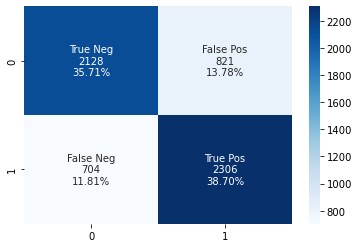

KNeighborsClassifier() has been fit


Accuracy : 0.7752978687699278


Precision Score :  0.7407087294727744


Recall Score :  0.8541528239202658


ROC AUC Score :  0.774482312265321


Classification Report

               precision    recall  f1-score   support

         0.0       0.82      0.69      0.75      2949
         1.0       0.74      0.85      0.79      3010

    accuracy                           0.78      5959
   macro avg       0.78      0.77      0.77      5959
weighted avg       0.78      0.78      0.77      5959



Confusion Matrix


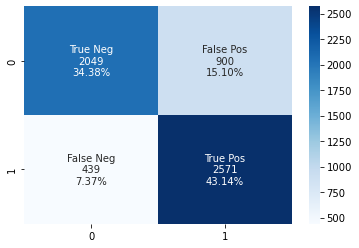

MultinomialNB() has been fit


Accuracy : 0.6514515858365497


Precision Score :  0.6847524752475248


Recall Score :  0.5744186046511628


ROC AUC Score :  0.6522482985955034


Classification Report

               precision    recall  f1-score   support

         0.0       0.63      0.73      0.67      2949
         1.0       0.68      0.57      0.62      3010

    accuracy                           0.65      5959
   macro avg       0.66      0.65      0.65      5959
weighted avg       0.66      0.65      0.65      5959



Confusion Matrix


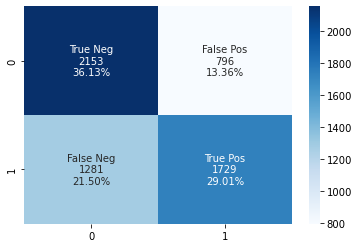

,Models,Accuracy,Runtime (s)
0,RandomForestClassifier,82.866,1.368357
1,KNeighborsClassifier,77.530,0.387520
2,LogisticRegression,74.408,0.118285
3,MultinomialNB,65.145,0.007728


In [45]:
models_to_test = [rf,lr,knn,mnb]#models we are testing
classification = Modelling(X_train,y_train,X_test,y_test,models_to_test) 
classification.fit()
classification.results()


- As the output speaks, we can see that Random Forest Classifier has the best accuracy with 83% and Knn the next best with 78% which is a good level of accuracy to move ahead.

- The False Positives for Logistic Regression are ~9%, which implies that the model is not skewed and is not false predicting.

- The Multinomial NB predicts ~14% of the data as the False Positive and ~ 20% of the data as False Negative.

Text(0, 0.5, 'Error Rate')

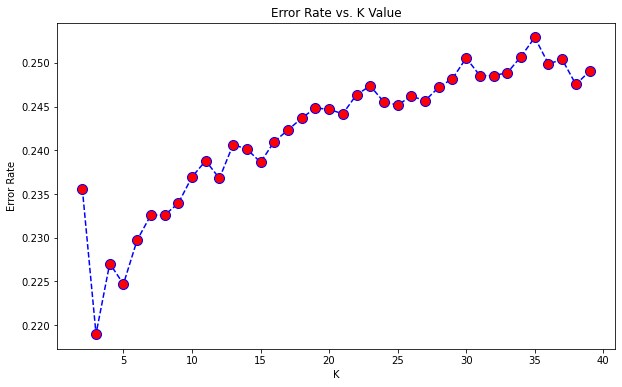

In [46]:
error_rate=[]
for i in range(2,40):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))


plt.figure(figsize=(10,6))
plt.plot(range(2,40),error_rate,color='blue', linestyle='dashed', marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

- K = 3 is the best for our model in this use case as we can see in the above graph.

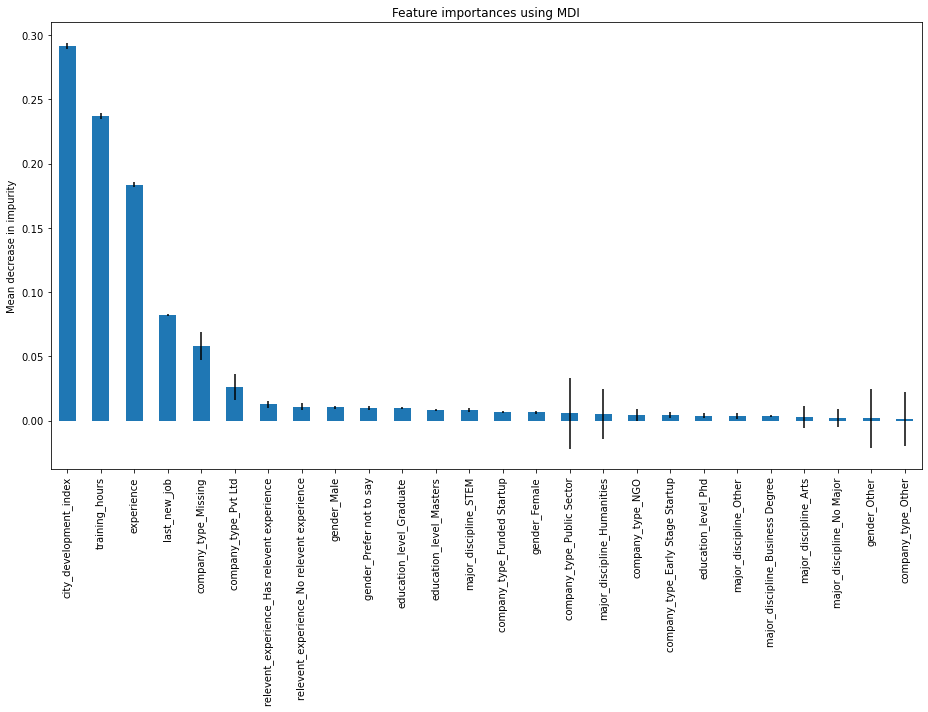

In [47]:
forest = RandomForestClassifier(random_state=0,n_estimators= 200)
forest.fit(X_train, y_train)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=X.columns.to_list()).sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(13, 10))
forest_importances.plot.bar(yerr=std, ax=ax,)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [48]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
bestfeatures = SelectKBest(score_func=chi2, k=10)
X_new = df_scaled.drop("target",axis = 1)
Y_new = df_scaled["target"]
fit = bestfeatures.fit(X_new,Y_new)
dfscores = pd.DataFrame(fit.scores_,columns = ["Score"])
dfcolumns = pd.DataFrame(X_new.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.nlargest(10,'Score')

,0,Score
15,company_type_Missing,795.789451
5,relevent_experience_No relevent experience,333.187590
16,company_type_Pvt Ltd,228.977773
24,city_development_index,146.071107
25,experience,131.684530
4,relevent_experience_Has relevent experience,93.342621
1,gender_Prefer not to say,61.968804
17,company_type_Funded Startup,61.824287
7,education_level_Masters,44.314016
23,last_new_job,43.927460


/Users/viswatej/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/viswatej/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<AxesSubplot:xlabel='0'>

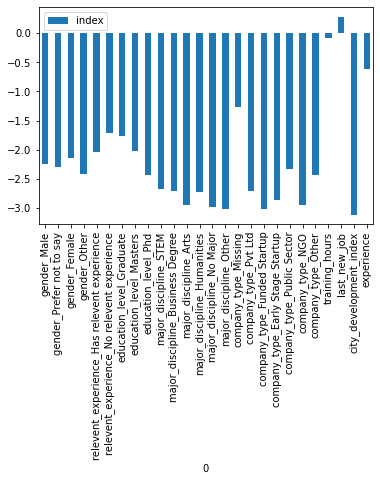

In [49]:
model = LogisticRegression()
Feature =[]
Score =[]
# fit the model
model.fit(X, Y)
# get importance
importance = model.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    Feature.append(X.columns[i])
    Score.append(v)

FI_LOGR=pd.DataFrame(Feature,Score).reset_index()
# plot feature importance
FI_LOGR.plot(kind='bar',x=FI_LOGR.columns[1])

<AxesSubplot:xlabel='0'>

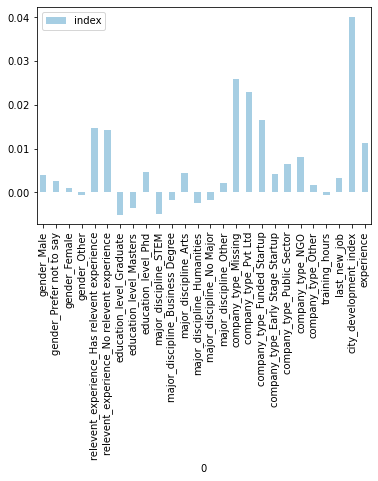

In [50]:
from sklearn.inspection import permutation_importance
gaussian_nb = GaussianNB()
gaussian_nb.fit(X_train, y_train)

imps = permutation_importance(gaussian_nb, X_test, y_test)
new_df=pd.DataFrame(X.columns,imps.importances_mean).reset_index()
new_df.plot(kind='bar',x=new_df.columns[1],color=plt.cm.Paired(np.arange(len(new_df))))


### Conclusion
- City Development Index and experience  has a major effect on the person in deciding to quit or stay in the company. Similarly the next impacting features are the "training hours","last new job". The company type and relevent experience has seems to have a minor effect in this case

- The level of education  and experience doesn't seem to have any effect on the person willing to leave


### Appendex

In [51]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = [f'principal component {i}' for i in range(2)])
# Explained Variance Ratio
pca.explained_variance_ratio_*100

array([23.2300514, 15.9461425])

In [52]:
xtrain,xtest,ytrain,ytest = train_test_split(principalDf,Y,test_size=0.3,random_state=0)
ytrain = np.ravel(ytrain)
ytest = np.ravel(ytest)
print(xtrain.shape,ytrain.shape,xtest.shape,ytest.shape)

(16685, 2) (16685,) (7151, 2) (7151,)


In [53]:
def train_model_red(model,xtrain,ytrain,xtest,ytest,n):
    pca = PCA(n_components=n)
    principalComponents = pca.fit_transform(X)
    principalDf = pd.DataFrame(data = principalComponents, columns = [f'principal component {i}' for i in range(n)])
    xtrain,xtest,ytrain,ytest = train_test_split(principalDf,Y,test_size=0.2,random_state=0)
    model.fit(xtrain,ytrain)
    return model.score(xtest,ytest)

In [54]:
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = X.columns.to_list()
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())
df

,0,1
0,PC0,company_type_Pvt Ltd
1,PC1,education_level_Graduate


- PCA actually doesn't have a lot of impact on our data, hence there is no point in using it in for suggestion or analysis.

/Users/viswatej/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:1614: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best alpha using built-in LassoCV: 0.000067
Best score using built-in LassoCV: 0.247588
Lasso picked 26 variables and eliminated the other 0 variables


/Users/viswatej/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.032e+00, tolerance: 5.959e-01
  model = cd_fast.enet_coordinate_descent(


Text(0.5, 1.0, 'Feature importance using Lasso Model')

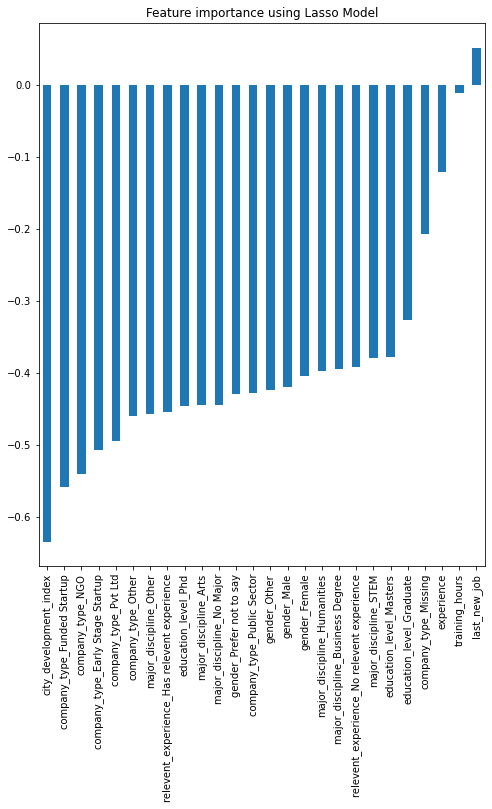

In [55]:
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso#Loading the dataset
reg = LassoCV()
reg.fit(X, Y)
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(X,Y))
coef = pd.Series(reg.coef_, index = X.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "bar")
plt.title("Feature importance using Lasso Model")